**Team Primary Roles**

---

* Grant: Created notebook at the beginning of the project (he might no longer be part of the team)
*   Kevin: Code writing and notebooks set up 
*   Pham: Code Writing (specifically defining functions of peak demands, heatmaps, sorted peak demand heat map)
* Joselyne: Writing portion and notebook cleaning

---

All team members participated in all activities but the main activities assigned to each were described above.


#Abstract

> Electric vehicles’ (EV) charging demand for electricity as well as the cost and fees of such varies over location and time. During peak-demand times the demand fees tend to be higher, which results in a high rate for those who use EV. In order to determine a plan that is cost-effective for users, it is helpful to determine the distribution in space an time of the EV charging events based on historical data. This will be accomplished by understanding the peak-demand charging energy in the stations across the state as well as the peak-demand charging time throughout different periods e.g., hourly, daily, weekly.




#Introduction

> The Colorado Energy Office (CEO) focuses on reducing greenhouse gas emissions and consumer energy costs by advancing clean energy, energy efficiency and zero emission vehicles to benefit all Coloradans. In an effort to preserve and help Colorado’s communities and natural environment, the CEO is working to enable a path to transition to 100% clean electricity generation by the year 2040. A specific method that the CEO is implementing to accomplish such a goal is promoting the use of EV's in the state. In order to help with this goal of transitioning to 100% clean energy, this project will use python code [(see here)](https://codeinstitute.net/blog/what-is-python-used-for/) and data collected over time on EV charging stations to determine the energy demand across EV's charging stations throughout the state of Colorado.
This will give the CEO a base knowledge to help improve and create a plan to reduce cost for the EV users. Such a plan will result in more cost effective clean energy for all Coloradans over time.




#Methods

> In this project, we are using the Excel file titled FY20EV.xlsx which contains all of the data for the EV project. This is a numerical file that contains stations addresses, transaction duration, transaction start and end time, charging energy (kWh), amongst other information regarding the EV. This file's size is 7,601,682 bytes.


> In this notebook, the data in the file is being utilized to find the peak demand of energy and transactions in certain categories such as weekdays vs weekends. 


##Dependencies

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os      # operating system routines
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from branca.element import Figure
import json


pd.__version__ #check version/verify import

'1.1.4'

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


**Note on accessing Data:** The data is hosted in a shared folder, to which everyone on this project has access. To work with the data affiliated with this notebook, right click the shared folder in Google Drive, then select 'Add Shortcut to Drive'. This will create a shortcut to the data folder located in your drive. As long as it isn't moved, the below block should run. If you move it, change the path in the third line below.

In [ ]:
cwd = os.getcwd()
pathCEO = cwd + '/drive/My Drive/'                       # always the same
pathFournier = 'Colab Notebooks/Math Clinic/2020fa/CEO/' # Path for Fournier
if os.path.exists(pathCEO + pathFournier) :
   pathCEO += pathFournier
pathCEO += 'CEO_data/'                                   # change this one if you move 'CEO_data'     
os.listdir(pathCEO)

['EV Charging Database FY20.csv',
 'Master sheet.xlsx',
 'FY20EV.xlsx',
 '.ipynb_checkpoints',
 'Counties in Colorado.geojson']

In [ ]:
io = pathCEO              # absolute path tested above
io += 'FY20EV.xlsx'       # file whose path starts from the same directory as the notebook
# df = pd.read_excel(io)  # omit sheet_name argument if only 1 sheet

##Data Frames & Definitions

Input data, assign data frames, get rid of seemingly useless columns, drop null values (approximately 5000). 



> This cell takes about 12 seconds to run (more than average cell)



In [ ]:
df = pd.read_excel(io) #Creates a data frame to read excel data
remove = ['Address 2','Country','Currency','End SOC','Ended By','Fee','Model Number',
          'Org Name','Plug In Event Id','Plug Type','Port Number','Port Type','Start SOC','State/Province','System S/N',
          'Transaction Date (Pacific Time)','User ID', 'Driver Postal Code'] #Choosen columns to be removed
df = df.drop(columns=remove) # remove useless columns
#df = df.dropna( ) # Drop null values 
colList = df.columns.to_list() 

Add new temporal columns.

*   Days of the week: 
> Monday = 0 ~ Sunday = 6
*   Weekdays vs. Weekend:
> Weekdays (0 - 4) = 1 and Weekends (5 - 6) = 0

In [ ]:
df['Start Date'] = pd.to_datetime(df['Start Date'])  #data frame to group data by start date
df['Start Hour'] = pd.DatetimeIndex(df['Start Date']).hour  #data frame to group data by start hour
df['MondaytoSunday'] = pd.to_datetime(df['Start Date']).dt.weekday.astype(int) #This line defines the weekdays and assigns them a number 0-6 as defined above
df['1-WD/0-WK'] = [1 if x <= 4 else 0 for x in df['MondaytoSunday']] #This line seperates the weekdays and the weekends and assigns them a number 0-6 as defined above
df['Charging Length'] =  pd.to_datetime(df['Charging Time (hh:mm:ss)'], format='%H:%M:%S', errors='coerce').dt.time
df['Month'] = pd.DatetimeIndex(df['Start Date']).month

Splitting data into Weekend vs Weekday by 6 hour time intervals

Definitions to create plots of peak demand from temporal perspective.
> Used number of transcactions rather than max energy for a more accurate understanding of drivers' behaviors.
*   Plots to show Start Time for each transactions on chosen day
1.   Monday through Sunday
2.   Weekday vs. weekend

In [ ]:
def Plot_peak_demand_per_day(Weekday,day):
    Weekday = df.loc[df['MondaytoSunday'] == Weekday ]  # Pick day (0-6)
    peak = Weekday['Start Hour'].value_counts()[:24] #make plot of Start Time for each Transactions on chosen day
    hour = np.arange(24) 
    plot = peak.loc[hour].plot(kind='bar')
    plt.xlabel("Start Hour")
    plt.ylabel("Number of transactions")
    plt.title(day)
    return plot
def Plot_Peak_Demand_by_transaction(Weekday, title):
    Weekday = df.loc[df['1-WD/0-WK'] == Weekday ]  # Pick  Weekday = 1 or Weekend = 0
    plt.title(title)
    return plot
def Plot_Peak_Demand_by_Energy_Weekday():
    pvt = pd.pivot_table(data = df, columns="County", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)') # can change it to station if we want
    pvt['WD'] = df['1-WD/0-WK']
    pvt_weekday = pvt.loc[pvt['WD'] == 1]
    plot_weekday = pvt_weekday.plot( subplots=False,use_index=True, logy = True, legend = False )
    return plot_weekday
def Plot_Peak_Demand_by_Energy_Weekend():
    pvt = pd.pivot_table(data = df, columns="County", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)') # can change it to station if we want
    pvt['WD'] = df['1-WD/0-WK']
    pvt_weekend = pvt.loc[pvt['WD'] == 0]
    plot_weekend = pvt_weekend.plot( subplots = False, use_index= True, logy = True, legend = False)
    return plot_weekend
def per_station(Weekday,Station):
    Station = df.loc[df['Address 1'] == Station]
    Weekday = df.loc[df['1-WD/0-WK'] == Weekday ]  # Pick  Weekday = 1 or Weekend = 0
    peak = Weekday['Start Hour'].value_counts()[:24] #make plot of Start Time for each Transactions on chosen day
    hour = np.arange(24)    
    plot = peak.loc[hour].plot(kind='bar')
    plt.xlabel("Start Hour")
    plt.ylabel("Number of transactions")
    #plt.title(Station)  # change 
    return plot
def peak_time(Weekday): # around 8AM
    Weekday = df.loc[df['1-WD/0-WK'] == Weekday ]  # Pick  Weekday = 1 or Weekend = 0
    t= Weekday['Start Hour'].tolist()
    peak_time = max(t,key =t.count) 
    return peak_time


Definitions of function to get max energy on/by:
 

1.  Weekend and Weekday
2.  time interval



In [ ]:
pvt = pd.pivot_table(data = df, columns="Address 1", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)', margins = True)
pvt

The code from cells 17-26 is intended to create heat maps on different points of information. 
The final heat maps will be interactive, the user can zoom in and out of the map as desired to see the physical distribution of our data points. The data represented on these maps will also adjust according to the changes being done to the window scale. The more the user zoom's in, the more segregated and clearly defined the data points (the colors) will be. For a larger and broader visualization of the information in the maps we can simply zoom out as desired.

>The colors in the map are: 
*   red (higher energy demand)
*   orange
*   yellow
*   green
*   light blue
*   royal blue (least energy demand).

With these heat maps there is also the option to toggle the different time groups on the layer control on the top right corner of the map, as well as choosing the type of view of the map.


> The four time options are: 
1.  00:00-06:00
2.  06:00-12:00
3.  12:00-18:00
4.  18:00-00:00

>The four map types are: 
1. Open street map
2. Stamen Terrain
3. Stamen Toner
4. cartodb positron






In [ ]:
 def generateBaseMap(default_location = [39.113014, -105.7821], default_zoom_start=7): 
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start,zoom_control= False )
    return base_map
base_map = generateBaseMap()

In [ ]:
#Create base_map1 for weekdays.
base_map1 = folium.Map(location=[39.113014, -105.7821], control_scale=True, zoom_start=8)

#Create the heat map data for weekdays 00:00-06:00 and add it base_map1
max_e_by_hr1 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(1,1)
heat_data_by_max_energy1 = max_e_by_hr1[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy1 = heat_data_by_max_energy1.values.tolist()
HeatMap(heatmap_data_by_energy1, name = 'Weekday 00:00-06:00').add_to(base_map1)


In [ ]:
#Create the heat map data for weekdays 06:00-12:00 and add it base_map1
max_e_by_hr2 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(1,2)
heat_data_by_max_energy2 = max_e_by_hr2[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy2 = heat_data_by_max_energy2.values.tolist()
HeatMap(heatmap_data_by_energy2,  name = 'Weekday 06:00-12:00').add_to(base_map1)

In [ ]:
#Create the heat map data for weekdays 12:00-18:00 and add it base_map1
max_e_by_hr3 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(1,3)
heat_data_by_max_energy3 = max_e_by_hr3[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy3 = heat_data_by_max_energy3.values.tolist()
HeatMap(heatmap_data_by_energy3, name = 'Weekday 12:00-18:00').add_to(base_map1)

In [ ]:
#Create the heat map data for weekdays 18:00-24:00 and add it base_map1
max_e_by_hr4 =MAX_E_BY_HOUR_BY_TIME_INTERVAL(1,4)
heat_data_by_max_energy4 = max_e_by_hr4[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy4 = heat_data_by_max_energy4.values.tolist()
HeatMap(heatmap_data_by_energy4, name = 'Weekday 18:00-24:00').add_to(base_map1)

In [ ]:
#Create the heat map data for weekdays (all time groups) and add it base_map2
max_e_by_hrWD = MAX_E_BY_HOUR_BY_WEEK_DAY(1)
heat_data_by_max_energyWD = max_e_by_hrWD[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energyWD = heat_data_by_max_energyWD.values.tolist()
HeatMap(heatmap_data_by_energyWD, name = 'Weekday ALL').add_to(base_map1)


In [ ]:
#Create base_map2 for weekends
base_map2 = folium.Map(location=[39.113014, -105.7821], control_scale=True, zoom_start=8)

#Create the heat map data for weekends 00:00-06:00 and add it base_map2
max_e_by_hr5 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(0,1)
heat_data_by_max_energy5 = max_e_by_hr5[['Latitude','Longitude', 'Energy (kWh)']] 
# Heatmap
heatmap_data_by_energy5 = heat_data_by_max_energy5.values.tolist()
HeatMap(heatmap_data_by_energy5, name = 'Weekend 00:00-06:00').add_to(base_map2)

In [ ]:
#Create the heat map data for weekends 06:00-12:00 and add it base_map2
max_e_by_hr6 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(0,2)
heat_data_by_max_energy6 = max_e_by_hr6[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy6 = heat_data_by_max_energy6.values.tolist()
HeatMap(heatmap_data_by_energy6, name = 'Weekend 06:00-012:00').add_to(base_map2)

In [ ]:
#Create the heat map data for weekends 12:00-18:00 and add it base_map2
max_e_by_hr7 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(0,3)
heat_data_by_max_energy7 = max_e_by_hr7[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy7 = heat_data_by_max_energy7.values.tolist()
HeatMap(heatmap_data_by_energy7, name = 'Weekend 12:00-18:00').add_to(base_map2)

In [ ]:
#Create the heat map data for weekends 18:00-24:00 and add it base_map2
max_e_by_hr8 = MAX_E_BY_HOUR_BY_TIME_INTERVAL(0,4)
heat_data_by_max_energy8 = max_e_by_hr8[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energy8 = heat_data_by_max_energy8.values.tolist()
HeatMap(heatmap_data_by_energy8, name = 'Weekend 18:00-24:00').add_to(base_map2)

In [ ]:
#Create the heat map data for weekends (all time groups) and add it base_map2
max_e_by_hrWE = MAX_E_BY_HOUR_BY_WEEK_DAY(0)
heat_data_by_max_energyWE = max_e_by_hrWE[['Latitude','Longitude', 'Energy (kWh)']] 
heatmap_data_by_energyWE = heat_data_by_max_energyWE.values.tolist()
HeatMap(heatmap_data_by_energyWE, name = 'Weekend ALL').add_to(base_map2)

In [ ]:
#Add tile layers for easier viewing
folium.TileLayer('openstreetmap').add_to(base_map1)
folium.TileLayer('Stamen Terrain').add_to(base_map1)
folium.TileLayer('Stamen Toner').add_to(base_map1)
folium.TileLayer('cartodbpositron').add_to(base_map1)
#Add layer control to toggle layers and different time groups
folium.LayerControl().add_to(base_map1)

In [ ]:
#Add tile layers for easier viewing
folium.TileLayer('openstreetmap').add_to(base_map2)
folium.TileLayer('Stamen Terrain').add_to(base_map2)
folium.TileLayer('Stamen Toner').add_to(base_map2)
folium.TileLayer('cartodbpositron').add_to(base_map2)
#Add layer control to toggle layers and different time groups
folium.LayerControl().add_to(base_map2)
#Show Weekend map

The following two cells were commented out because they produce the error "NameError: name 'fig2' is not defined" when we run it. We decided to not delete it as it may or may not be of importance during our final steps of creating the heat maps.  

Following code cell produced an error. "SyntaxError: invalid syntax". We are working on figuring out the problem.

#Results & Discussion

> The following are the graphs and maps obtained from the code above. We will describe each of them as well as what they tells us in terms of the EV project. 



##Graphs

###Boxplots
Following boxplots represent each county's energy usage by start hour. (Cell takes about 15 sec to run, more than average)



> These graphs were separated into counties in order to be able to awknowledge more clearly the energy that is being used throught the hours of any given day. We can see that there are some counties like Eagle County, El Paso County, Garfield County, etc that have a significantly larger number of transcations throughout time compared to counties like Baca county, Moffat County, Kiowa County, etc. Analyzing the peak demand in energy usage by county gives us a more accurate representation of the demand of EV charging stations which is key if the ultimate goal if to generate a plan to decrease the users fees. 

In [ ]:
df.groupby('County').boxplot(column='Energy (kWh)',by='Start Hour', figsize=(80,80));  


###Spaghetti Plots
Following plot shows energy demand in kWh across all individual stations. 

> **Note on this plot** We are considering to take this plot out of the project and replacing it with a pcolor plot for better and more visually "easy-to-understand" data results. 




In [ ]:
pvt.plot( subplots=False,use_index=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

The two following graphs show the peak demand energy in kWh's separated by weekdays and weekends. 


> The first graph shows unexpected results. What the plot tells us is that between midnight to approx. 10:00 am and after 4:00 pm, the charging energy demand is significantly less (which seems suspicious to us). 


> **Note on plot:** Just as before, we are considering to replace the plot with a pcolor plot and will have it by the 12/1


In [ ]:
Plot_Peak_Demand_by_Energy_Weekday()

In [ ]:
Plot_Peak_Demand_by_Energy_Weekend()

###Heat Maps

As mentioned before, the following heat maps are interactive which allows the user to zoom in and out. 
>The colors in the maps are: 
*   red (higher energy demand)
*   orange
*   yellow
*   green
*   light blue
*   royal blue (least energy demand)

The user can also switch the time intervals and the map type by clicking the **Layer symbol in the top right corner**



**Peak Demand Energy on WEEKDAYS**

---



In [ ]:
base_map1

**Peak Demand Energy on WEEKENDS**

---

In [ ]:
base_map2

**Discussion:**  When arranging both maps on a scale of 50km:50mi we are able to see some differences in peak demand energy amongst weekdays and weekends.


1.   During the Weekdays the overall demand is higher across the state. We can tell this by noticing that there are more blue 'spots' in the first map.
2.   If we only compare the two maps from 00:00-06:00, we realize that at this time the energy demand is higher on the weekdays.
3.   From 06:00-12:00, we see that Colorado Springs has significantly more demand on the weekdays than on the weekends, but places like Aspen has more demand on the weekend. Overall, there is more demand across the state on the weekdays during this time slot.
4.    From 12:00-18:00, the energy demand increases on both weekdays and weekdays compared to the charging demand from 06:00-12:00
5.    Finally, from 12:00-24:00, the energy demand is lower on the weekends across all state (with the exception of Aspen) compared to the weekdays.


#Conclusions


> Our conclusions are still in progress. We expect to be able to see in the maps (some are still in progress) the peak demand of transactions in all stations and see when these peak demands are taking place i.g. weekday or weekend, which specific day of the week, etc. When the code for these maps is finalized, we will be able to compare those results to our other plots and make a more accurate description of when most users are charging their vehicles.

For the result that we do know as of right now, we can see that the energy demand is higher overall compared to the weekends. Some counties have higher demands than others but most follow the same patter (higher on weekdays than weekends). However, we were able to notice that Aspen (located in Pitkin County) the energy demand was higher on the weekends compared to the week days. 






# Work in Progress

The following code is not yet finished. We have found the problem that gives us the error and are working on fixing it. We are planning on having it done as soon as we get back from thanksgiving break. We are trying to have a cloropeth map [(see here)](https://plotly.com/python/choropleth-maps/) running and ready to go for the penultimate notebook check. 

In [ ]:
# Choropleth
# Define data for choropleth on Weekday
def Colorado_data_Weekday(Weekday): # Pick 1 for Weekday 0 for Weekkend
  max_e_by_county_weekday=MAX_E_BY_HOUR_BY_WEEK_DAY(Weekday)

#Some string mofidication for county to match with GEOJSON propeties.
  county=[] 
  for i in max_e_by_county_weekday['County']:
    county.append(i[:-7])  
  max_e_by_county_weekday['county']= county
  max_e_by_county_weekday['county']= max_e_by_county_weekday['county'].str.upper() # Example : Denver county  -> DENVER 
  Colorado_data_Weekday = max_e_by_county_weekday[['county','Start Hour','Energy (kWh)']] 
  return Colorado_data_Weekday

#Import Geojson data
geojson= pathCEO +'Counties in Colorado.geojson'
with open(geojson) as f:
  Colorado_geo = json.load(f)

#Example: Display Colorado_data using for choropleth on Weekday
Colorado_data_Weekday(1)

county  Start Hour  Energy (kWh)
0      LA PLATA           8      2399.134
1      LA PLATA           6      2346.410
2    SAN MIGUEL          14       550.657
3          WELD           9       188.278
4         EAGLE           9       110.709
..          ...         ...           ...
103     EL PASO          10         0.178
104   ARCHULETA          16       437.371
105     PROWERS           8        39.106
106     LARIMER           9       147.581
107     LARIMER           7      1289.461

[108 rows x 3 columns]

In [ ]:
# Choropleth code
# Build Choropleth for peak energy on weekday and weekend
def Choropleth_Energy_Weekday(Weekday):
  base_map = generateBaseMap()
  folium.Choropleth( 
    geo_data=Colorado_geo, # Geographical data
    name='choropleth',
    data=Colorado_data_Weekday(Weekday),
    columns=['county', 'Energy (kWh)'],
    key_on = 'feature.properties.county',  #   Problem is right here, key_on = ????
    fill_color='YlOrRd',
    nan_fill_color = 'White',
    fill_opacity=0.8,
    line_opacity=0.2,
    bins = [0,300,600,900,1200,1500], 
    legend_name='Total Energy(kWh) at Peak Time'
 ).add_to(base_map)
  return base_map


In [ ]:
Choropleth_Energy_Weekday(1) # Pick 1 for Choropleth of peak energy on Weekday

In [ ]:
Choropleth_Energy_Weekday(0) # Pick 0 for Choropleth of peak energy on Weekend

In [ ]:
# Build Choropleth for peak time on weekday and weekend
def Choropleth_Time_Weekday(Weekday):
  base_map = generateBaseMap()
  folium.Choropleth( 
    geo_data=Colorado_geo, # Geographical data
    name='choropleth',
    data=Colorado_data_Weekday(Weekday),
    columns=['county', 'Start Hour'],
    key_on = 'feature.properties.county',  #   Problem is right here, key_on = ????
    fill_color='YlGnBu',
    nan_fill_color = 'White',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Peak Time'
 ).add_to(base_map)
  return base_map


In [ ]:
Choropleth_Time_Weekday(1) # Pick 1 for Choropleth  of peak time on weekday, Peak time is around 8:00 AM - 15:00 PM

In [ ]:
Choropleth_Time_Weekday(0) # Pick 0 for Choropleth  of peak time on weekday,

In [ ]:
pvt = pd.pivot_table(data = df, columns="Address 1", index=['Start Hour'], aggfunc = 'max', values = 'Energy (kWh)', margins=True)
pvt2 = pd.pivot_table(data = df, columns="Start Hour", index=['Address 1'], aggfunc = 'sum', values = 'Energy (kWh)', margins=True)
pvt3 = pd.pivot_table(data = df, columns="Address 1", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)')
pvt4 = pd.pivot_table(data = df, columns="Start Hour", index=['Address 1'], aggfunc = 'sum', values = 'Energy (kWh)')
pvt3

Address 1   1-29 Stewart St  ...  Technology Parkway
Start Hour                   ...                    
0                   116.515  ...             109.812
1                    40.525  ...              10.877
2                       NaN  ...              45.640
3                     1.802  ...               1.297
4                    36.928  ...             276.334
5                   127.942  ...            1314.739
6                    81.973  ...             943.492
7                   749.063  ...            1299.717
8                  2410.258  ...             903.277
9                   631.207  ...            1155.619
10                  327.132  ...             789.880
11                  336.060  ...             496.410
12                  205.561  ...             731.042
13                  286.376  ...             749.779
14                  270.166  ...             515.620
15                  133.472  ...             145.228
16                  214.597  ...              89.240
17                  271.697  ...             401.597
18                  364.456  ...               1.305
19                  382.602  ...              38.447
20                  350.563  ...                 NaN
21                  341.966  ...              49.238
22                   76.396  ...             182.014
23                   49.800  ...              46.941

[24 rows x 108 columns]

In [ ]:
maxaddress = pvt3.max()
maxhours = pvt4.max()
maxhours.plot(figsize = (40,5), kind = 'line', ax)

In [ ]:
maxaddress.plot(figsize = (40,5), kind = 'bar' )

In [ ]:
pvt3 = pd.pivot_table(data = df, columns="1-WD/0-WK", index=['City'], aggfunc = 'max', values = 'Energy (kWh)')
pvt3.plot(kind = 'bar', figsize = (20,10))
pvt3

In [ ]:
pvt4 = pd.pivot_table(data = df, columns="1-WD/0-WK", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)')
pvt4.plot(figsize = (20,10))
pvt4

In [ ]:
# Fill in missing counties
df.loc[df['Address 1'] == 'S Railroad St','County'] = 'Larimer County'          #106-S Railroad St	- Larimer County
df.loc[df['Address 1'] == '781 E Industrial Blvd','County'] = 'Pueblo County'   #94 - 781 E Industrial Blvd - Pueblo County
df.loc[df['Address 1'] == '501 S Galena St','County'] = 'Denver County'         #74 - 501 S Galena St	- Denver County
df.loc[df['Address 1'] == '3425 south Shields','County'] = 'Larimer County'     #61 - 3425 south Shields- Larimer
df.loc[df['Address 1'] == '1309 East 3rd Ave','County'] = 'Denver County'       #14 - 1309 East 3rd Ave - Denver County

In [ ]:
# By Nhat Hoang Pham
def MAX_DEMAND_BY_HOUR_BY_TIME_INTERVAL(Weekday,Timeinterval,Demand): # ADD TIME INTERVAL
 
  Weekday = df.loc[df['1-WD/0-WK'] == Weekday ] # Pick 1 for Weekday , Pick 0 for Weekend
  # Time interval: Pick 0(For the whole day) or Pick 1(0-6); 2(6-12); 3(12-18) ;4(18-24)
  if Timeinterval == 0:
    Weekday_time = Weekday
  elif Timeinterval == 1:
    Weekday_time = Weekday[Weekday['Start Hour'] <= 5]
  elif Timeinterval == 2:
    Weekday_time = Weekday[(Weekday['Start Hour'] > 5) & (Weekday['Start Hour'] <= 11)]
  elif Timeinterval == 3:
    Weekday_time = Weekday[(Weekday['Start Hour'] > 11) & (Weekday['Start Hour'] <= 17)]
  elif Timeinterval == 4:
    Weekday_time = Weekday[Weekday['Start Hour'] > 17] 
  else:
    return ("Wrong Input for Time Interval")

  # Create Using data to merge
  grouped = Weekday_time[['Address 1', 'County','Longitude','Latitude','1-WD/0-WK']]
  grouped = grouped.drop_duplicates(subset = ['Address 1'], ignore_index = True) # drop duplicates by address
  Using_data = grouped.sort_values('Address 1',ignore_index=True ) # sort aphabetical

  #Create pivot table for peak energy  on Weekday or on Weekend
  pvt_e = pd.pivot_table(data = Weekday_time, columns="Address 1", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)')
  # Create pivot table for peak number of transactions on Weekday of Weekend
  pvt_trans = Weekday_time.groupby(["Address 1","Start Hour"])["Start Hour"].count().unstack('Address 1', fill_value = 0)

  # Pick Demand measured by number of transactions or demand measured by energy
  if Demand == 'Peak Number of Transaction':
    pvt_W = pvt_trans
  elif Demand == "Peak Energy (kWh)":
    pvt_W = pvt_e
  else:
    return ("Wrong Input for Demand")
  #Create dataframe for the peak energy at the peak time
  peak_time = pd.DataFrame(pvt_W.idxmax().values.tolist(),columns = ['Start Hour']) # Peak time
  max_demand_at_peak_time = pd.DataFrame(pvt_W.max().values.tolist(), columns = [Demand]) # Total Energy (kWh) at peak time
  address = pd.DataFrame(pvt_W.columns.to_list(), columns =['Address 1']) # Get Address 1
  frames = [address,peak_time,max_demand_at_peak_time]
  Master_data = pd.concat(frames,axis = 1) # get single data frame contain address peak time max e
  MAX_DEMAND = Master_data.merge(Using_data, left_on='Address 1', right_on='Address 1') # Merge data
  
  return MAX_DEMAND

# Three options :
# 1) Weekday: Pick 1 for Weekday or Pick 0 for Weekend
# 2) Timeinterval: Pick 0(For the whole day) or Pick 1 for (0-6); Pick 2 for (6-12); Pick 3 for (12-18) ;Pick 4 for (18-24)
# 3) Demand: Type "Peak Number of Transaction"  or type "Peak Energy (kWh)" 

# Example
MAX_DEMAND_BY_HOUR_BY_TIME_INTERVAL(1,1,'Peak Number of Transaction')# Example max number of transactions at peak time on weekday, from 0 -6 AM

Address 1  Start Hour  ...   Latitude 1-WD/0-WK
0                        1-29 Stewart St           5  ...  37.244526         1
1              1010 Three Springs Avenue           4  ...  37.235104         1
2          112 Chambers / Fairgrounds Rd           3  ...  39.659035         1
3                     112 Fairgrounds Rd           0  ...  39.659077         1
4                        121 W Pitkin St           5  ...  40.570736         1
5                         127 E Kiowa St           5  ...  38.834599         1
6                       130 S Nevada Ave           5  ...  38.831806         1
7                         1309 E 3rd Ave           0  ...  37.277199         1
8                      1309 East 3rd Ave           0  ...  37.277584         1
9                            137 10th St           1  ...  40.487690         1
10                         150 Grand Ave           4  ...  37.345501         1
11                      1508 Center Ave.           4  ...  40.568245         1
12               1521 Hancock expressway           4  ...  38.811863         1
13                155-199 S Harrison Ave           5  ...  40.079082         1
14                        1634 W Plum St           0  ...  40.576965         1
15                     2 S Commercial St           3  ...  37.692932         1
16                      200 N Wilson Ave           5  ...  40.395275         1
17                       208 S Spring St           5  ...  39.188610         1
18                          22 Second St           5  ...  39.927845         1
19                    2301 Research Blvd           0  ...  40.556717         1
20               2307-2313 Mt Werner Cir           5  ...  40.458042         1
21                           234 Main St           0  ...  39.067722         1
22                    2400 Research Blvd           5  ...  40.556660         1
23                       241 E Meadow Dr           5  ...  39.642002         1
24                    241 East Medow Dr.           3  ...  39.642101         1
25                      243 Colorado Ave           2  ...  39.066029         1
26                      250 Carriage Way           5  ...  39.208904         1
27                    255 Gold Rivers Ct           0  ...  39.367767         1
28                         2625 35th Ave           0  ...  40.394600         1
29                          2855 Mesa Rd           3  ...  38.872387         1
30                 300 S Bonaventure Ave           4  ...  37.174213         1
31                         323 W Lake St           4  ...  40.568283         1
32                     335 W Elkhorn Ave           5  ...  40.377956         1
33                     3404 E Harmony Rd           5  ...  40.525528         1
34                    3425 south Shields           0  ...  40.540508         1
35                     427 Rio Grande Pl           2  ...  39.191444         1
36                   450 Miller Ranch Rd           5  ...  39.643078         1
37                   4740 Flintridge Dr.           5  ...  38.901310         1
38                4801 signal tree drive           0  ...  40.520535         1
39                       501 E Lowell St           5  ...  38.476448         1
40                       501 S Galena St           5  ...  39.187279         1
41                        531 Edison Ave           0  ...  37.467426         1
42                       551 Broadway St           1  ...  39.651951         1
43                       5615 Wills Blvd           0  ...  38.331684         1
44                       585 Cemetery Ln           5  ...  39.196163         1
45                        625 N Polk Ave           1  ...  37.633724         1
46                    691 North St Vrain           0  ...  40.377861         1
47                        723 Horizon Dr           0  ...  39.109634         1
48               7290 Commerce Center Dr           1  ...  38.936623         1
49                       84 Carriage Way           4  ...  39.208862         1
50

In [ ]:
# Create a pivot table for number of transactions 
pvt_trans = df.groupby(["Address 1","Start Hour"])["Start Hour"].count().unstack('Address 1', fill_value = 0)
pvt_trans

Address 1   1-29 Stewart St  ...  Technology Parkway
Start Hour                   ...                    
0                         8  ...                   6
1                         5  ...                   1
2                         0  ...                   3
3                         1  ...                   1
4                         5  ...                  41
5                        17  ...                 139
6                         5  ...                  46
7                        55  ...                 108
8                       126  ...                  94
9                        59  ...                 103
10                       42  ...                  78
11                       50  ...                  55
12                       35  ...                  90
13                       41  ...                  87
14                       43  ...                  58
15                       21  ...                  23
16                       41  ...                  16
17                       44  ...                  19
18                       39  ...                   1
19                       36  ...                   1
20                       35  ...                   0
21                       20  ...                   1
22                        8  ...                  10
23                        7  ...                   3

[24 rows x 108 columns]

In [ ]:
def MAX_TRANS_BY_HOUR_BY_WEEK_DAY(Weekday):
  #Create using Data to merge
  Weekday = df.loc[df['1-WD/0-WK'] == Weekday ]
  grouped = Weekday[['Address 1', 'County','Longitude','Latitude','1-WD/0-WK']]
  grouped = grouped.drop_duplicates(subset = ['Address 1'], ignore_index = True) # drop duplicates by address
  Using_data = grouped.sort_values('Address 1',ignore_index=True ) # sort aphabetical
  
  #Create pivot table on weekday and weekend
  pvt_tran = Weekday.groupby(["Address 1","Start Hour"])["Start Hour"].count().unstack('Address 1', fill_value = 0)

  peak_time = pd.DataFrame(pvt_tran.idxmax().values.tolist(),columns = ['Start Hour']) # Peak time
  max_trans_at_peak_time = pd.DataFrame(pvt_tran.max().values.tolist(), columns = ['Number_of_Transactions']) # Total Energy (kWh) at peak time
  address = pd.DataFrame(pvt_tran.columns.to_list(), columns =['Address 1']) # Get Address 1
  frames = [address,peak_time,max_trans_at_peak_time]
  Master_data = pd.concat(frames,axis = 1) # get single data frame contain address peak time max e
  MAX_Trans = Master_data.merge(Using_data, left_on='Address 1', right_on='Address 1')
  return MAX_Trans
MAX_TRANS_BY_HOUR_BY_WEEK_DAY(0)

Address 1  Start Hour  ...   Latitude 1-WD/0-WK
0                        1-29 Stewart St          19  ...  37.244514         0
1              1010 Three Springs Avenue          16  ...  37.235104         0
2                         104 Society Dr          15  ...  37.947212         0
3                        10601 W 10th St           7  ...  40.417641         0
4          112 Chambers / Fairgrounds Rd          16  ...  39.659035         0
..                                   ...         ...  ...        ...       ...
89                           99 S 3rd St          11  ...  39.575008         0
90  Centennial Park, San Juan River Walk           9  ...  37.265659         0
91                   Enchanted Forest Rd          14  ...  38.089680         0
92                         S Railroad St          10  ...  38.841904         0
93                    Technology Parkway           5  ...  40.525913         0

[94 rows x 7 columns]

Address 1           Start Hour
1-29 Stewart St     0              8
                    1              5
                    3              1
                    4              5
                    5             17
                                  ..
Technology Parkway  18             1
                    19             1
                    21             1
                    22            10
                    23             3
Name: Start Hour, Length: 1691, dtype: int64

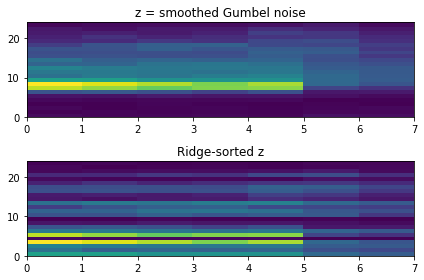

In [ ]:
pvt_6 = pd.pivot_table(data = df, columns="MondaytoSunday", index=['Start Hour'], aggfunc = 'sum', values = 'Energy (kWh)',fill_value= 0)
# Heatmap Matrix Monday to Sunday (0-6)
Z = pvt_6.to_numpy()
fig, ax = plt.subplots(2, 1 ) 
ax[0].pcolor(Z)
ax[0].set_title('z = smoothed Gumbel noise')
index_array = np.argsort(                   # get the row indexes of the sort ...
   np.argmax(Z, axis=1))                   # ... of the column indexes of the column-max
ax[1].pcolor(Z[index_array,:])              # order the same Z rows so that ridge is revealed
ax[1].set_title('Ridge-sorted z')
fig.tight_layout()
plt.show()